# Medicaid Generosity by State

When evaluating the likelihood of Medicaid receipt, one must consider that the program rules change meaningfully across states.  It is, therefore, important to accomodate cross-state heterogeneity in any specification to be estimated.  However, the inclusion of 50 state dummies creates a great deal of sparsity, which taxes the numerical capacity of optimization routines.  A more continuous optimization surface can improve the stability and efficiency of the estimation process.

It would be ideal to have a single measure that captures the multi-dimensional concept of program generosity for each state.  Gathering and synthesizing the program rules across all states, however, is very labor intensive.  When this must be done for a period exceeding 30 years, the labor costs are likely to exceed the efficiency benefits.  A well-conceive proxy, on the other hand, might provide most of the benefit at a fraction of the cost.

When we think about the drivers of Medicaid benefit pursuit, there are two basic components:

1. *Ease of Access* - the eligibility tests for Medicaid dictate the benefit supply by constraining the sub-population that can receive the benefits to begin with.
2. *Benefit Value* - the size of the benefit itself dictates recipient demand, insofar as it is the utility attached to the transfer that induces participation from recipients.

We have little ability to efficiently capture the supply side element in a reasonable time period.  Indeed, it is not even clear that the rules for all states are feasibly available as far back as 1980.  We do have some potential for the construction of a proxy on the demand side.  Ideally, we would use the benefits per enrollee, but those data only go back until 1998 (the advent of electronic data storage in the Medicaid program).  A weaker alternative would be to capture the Medicaid expenditure per impoverished person.  We can get the Medicaid expenditure for each state from [NIPA regional accounts](http://www.bea.gov/iTable/index_regional.cfm), and [poverty data from the Census](https://www.census.gov/hhes/www/poverty/data/historical/people.html).  

We have already processed poverty data in **`pov_hist_state_1980_2014`**, but the NIPA data is a bit more involved.  The reason is the Medicaid figure tables are too large to download for several years at a time, and even then it would require a lot of post hoc manual cleaning.  This right here is why APIs exist.

In this Notebook, we will use the BEA API to capture Medicaid expenditure back to 1980.  We will then construct an output set that contains Medicaid expenditure per impoverished person by state and year (1980-2014).

In [139]:
#Data Management
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

#API Tools
import requests
import time

#Visualization
import seaborn as sb

%pylab inline

plt.rcParams['axes.edgecolor']='k'
plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.facecolor']=(1,1,1,0)
plt.rcParams['grid.color']='k'
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.linewidth']=0.3

Populating the interactive namespace from numpy and matplotlib


## Data Acquisition

The first task is to see that our API is working, and inspect the variables we have at our disposal.  The data structure is hierarchical, and in this case, our data is housed in a table.  We already know we are looking for information contained in the regional income accounts, so the first step is looking at the tables we can access within said accounts.  Specifically, we want to check the transfer related tables

In [35]:
#Capture the API key
key='027446AC-F203-4834-BF78-6E41378DAF42'

#Request table list via BEA API
table_list=requests.get('http://www.bea.gov/api/data?&UserID='+key+'=&method=GetParameterValues&'+\
                        'datasetname=RegionalIncome&ParameterName=TableName')

#For each table in the request...
for tbl in table_list.json()['BEAAPI']['Results']['ParamValue']:
    #...if the table contains state level transfer info...
    if 'transfer' in tbl['Desc'].lower():
        #...report back
        print tbl

{u'Key': u'CA35', u'Desc': u'Personal Current Transfer Receipts (Non-Industry) [A]'}
{u'Key': u'SA35', u'Desc': u'Personal Current Transfer Receipts (Non-Industry) [A]'}
{u'Key': u'SQ35', u'Desc': u'Personal Current Transfer Receipts (Non-Industry) [Q]'}


We have three options: `CA35, SA35, & SQ35`.  The first letter in each table name speaks to geography. `C` indicates county (or generally local), while `S` indicates state.  The second letter speaks to frequency of observation. `A` indicates annual, while `Q` indicates quarterly.  We want annual state level values, so `SA35` is our table.

There are, of course, many values contained in this table.  We only want Medicaid expenditures.  To pull the actual data, we need to know which line number corresponds to Medicaid in the `SA35` table.

In [41]:
#Request line number list via BEA API
line_no_list=requests.get('http://www.bea.gov/api/data?&UserID='+key+'=&method=GetParameterValuesFiltered&'+\
                          'datasetname=RegionalIncome&TargetParameter=LineCode&TableName=SA35')

#For each variable in the table...
for ln in line_no_list.json()['BEAAPI']['Results']['ParamValue']:
    #...if the table contains state level transfer info...
    if 'medicaid' in ln['Desc'].lower():
        #...report back
        print ln


{u'Key': u'2221', u'Desc': u'[SA35] Medicaid'}


Medicaid data is stored at the position demarcated by line number `2221` in the `SA35` table.  We can now pull the entire set of values for all years and states between 1980 and 2014.  To pull multiple years, we just need to provide a comma-delimited list for the `Year` parameter.

In [56]:
#Generate list of years
years=','.join([str(val) for val in range(1980,2015)])

#Request data
data_list=requests.get('http://www.bea.gov/api/data?&UserID='+key+'=&method=GetData&'+\
                       'datasetname=RegionalIncome&TableName=SA35&GeoFIPS=STATE&LineCode=2221&Year='+years)

#Capture data component of JSON object
data_json=data_list.json()['BEAAPI']['Results']['Data']

data_json[0]

{u'CL_UNIT': u'thousands of dollars',
 u'Code': u'SA35-2221',
 u'DataValue': u'487380000',
 u'GeoFips': u'00000',
 u'GeoName': u'United States',
 u'TimePeriod': u'2014',
 u'UNIT_MULT': u'3'}

Now, we have a list of JSON components, which for our purposes are dictionaries.  It is a simple matter convert each of them into a single line DataFrame.

In [57]:
DataFrame(data_json[100],index=[100])

,CL_UNIT,Code,DataValue,GeoFips,GeoName,TimePeriod,UNIT_MULT
100,thousands of dollars,SA35-2221,21275988,12000,Florida,2014,3


We can concatenate them together for a single set.

In [58]:
#Create container to hold each data row
data_rows=[]

#For each data row...
for i in range(len(data_json)):
    #...capture the row...
    tmp_row=DataFrame(data_json[i],index=[i])
    #...and throw it in data_rows
    data_rows.append(tmp_row)
    
#Concatenate into single DF
data=pd.concat(data_rows)

data

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
0,thousands of dollars,SA35-2221,487380000,00000,United States,NaN,2014,3
1,thousands of dollars,SA35-2221,439719000,00000,United States,NaN,2013,3
2,thousands of dollars,SA35-2221,369248000,00000,United States,NaN,2009,3
3,thousands of dollars,SA35-2221,396633000,00000,United States,NaN,2010,3
4,thousands of dollars,SA35-2221,405674000,00000,United States,NaN,2011,3
5,thousands of dollars,SA35-2221,417275000,00000,United States,NaN,2012,3
6,thousands of dollars,SA35-2221,304413000,00000,United States,NaN,2005,3
7,thousands of dollars,SA35-2221,299104000,00000,United States,NaN,2006,3
8,thousands of dollars,SA35-2221,324178000,00000,United States,NaN,2007,3
9,thousands of dollars,SA35-2221,338322000,00000,United States,NaN,2008,3


In [59]:
data.TimePeriod.value_counts()

2012    60
2013    60
2010    60
2011    60
2009    60
2008    60
2014    60
2005    60
2007    60
2006    60
Name: TimePeriod, dtype: int64

Not going to lie, I was a little alarmed when I saw the data stop at 2005.  However, spot checking does ensure that the data are available back to 1980.  It would appear that there is a limit on volume of data that may be pulled at one time.  This is not uncommon - it enables management of demand from their side.  The solution here is to build up subsets like the one above, and just insert a wait period after each one of a couple seconds.  This is most easily achieved in a function.  We will do this in five year increments.

In [68]:
def data_sub_request(years):
    #Request data
    data_list=requests.get('http://www.bea.gov/api/data?&UserID='+key+'=&method=GetData&'+\
                           'datasetname=RegionalIncome&TableName=SA35&GeoFIPS=STATE&LineCode=2221&Year='+years)

    #Capture data component of JSON object
    data_json=data_list.json()['BEAAPI']['Results']['Data']

    #Create container to hold each data row
    data_rows=[]

    #For each data row...
    for i in range(len(data_json)):
        #...capture the row...
        tmp_row=DataFrame(data_json[i],index=[i])
        #...and throw it in data_rows
        data_rows.append(tmp_row)

    #Concatenate into single DF
    data=pd.concat(data_rows)

    return data

#Create container for data subsets
data_subs=[]

#Create a container to hold of 5-year subsets
year_subs=[]

#For each starting year...
for start_yr in range(1980,2015,5):
    #...capture the five year increment
    year_subs.append(','.join([str(val) for val in range(start_yr,start_yr+5)]))
    
#For each year subset...
for yrsub in year_subs:
    print 'Capturing data for '+yrsub
    #...capture the data subset...
    data_tmp=data_sub_request(yrsub)
    #...throw it in data_subs...
    data_subs.append(data_tmp)
    #...and wait a bit before getting the next subset
    print '>> Sleeping...'
    time.sleep(3)
    
#Concatenate data subset together
data=pd.concat(data_subs)

data.TimePeriod.value_counts()

Capturing data for 1980,1981,1982,1983,1984
>> Sleeping...
Capturing data for 1985,1986,1987,1988,1989
>> Sleeping...
Capturing data for 1990,1991,1992,1993,1994
>> Sleeping...
Capturing data for 1995,1996,1997,1998,1999
>> Sleeping...
Capturing data for 2000,2001,2002,2003,2004
>> Sleeping...
Capturing data for 2005,2006,2007,2008,2009
>> Sleeping...
Capturing data for 2010,2011,2012,2013,2014
>> Sleeping...


2009    60
1988    60
2012    60
2013    60
2010    60
2011    60
2014    60
1989    60
1981    60
1990    60
1980    60
1983    60
1982    60
1985    60
1984    60
1987    60
1991    60
1993    60
2008    60
2003    60
2005    60
2004    60
2007    60
2006    60
2001    60
2000    60
2002    60
1992    60
1998    60
1999    60
1996    60
1997    60
1994    60
1995    60
1986    60
Name: TimePeriod, dtype: int64

That's more like it.  As can be seen, all of these data have come through as strings.

In [70]:
data.describe()

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
count,2100,2100,2100,2100,2100,70,2100,2100
unique,1,1,2099,60,60,1,35,1
top,thousands of dollars,SA35-2221,0,93000,Maine,*,2009,3
freq,2100,2100,2,35,35,70,60,2100


We also don't need all of it.  We should take note that all values are in $Th, and retain the following:  year, state, and value.

In [79]:
#Subset to the relevant variables
data2=data[['TimePeriod','GeoName','DataValue']]

#Convert to new column names
data2.columns=['year','state','mcaid_exp']

#Convert numeric columns
data2['year']=data2['year'].astype(int)
data2['mcaid_exp']=data2['mcaid_exp'].astype(float)

#Set index
data2.set_index(['state','year'],inplace=True)

#Sort index
data2.sortlevel(0,inplace=True)

data2.head(10)

C:\Users\marvinw\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\marvinw\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mcaid_exp
state   year           
Alabama 1980     292520
        1981     280381
        1982     350431
        1983     361170
        1984     383259
        1985     448813
        1986     427865
        1987     437244
        1988     481940
        1989     595991

## Medicaid Expenditure Normalized by Impoverished Population

We are now in a position to build our demand side proxy measure for Medicaid generosity.  Let's read in the poverty data.

In [153]:
#Read in data
pov=pd.read_csv('pov_by_state_1980_2014.csv')
 
#Set index
pov.set_index(['state','year'],inplace=True)

pov.head(10)

pop  num_pov  st_err_num  pct_pov  st_err_pct  st
state   year                                                    
Alabama 1980  3831      810          80     21.2        1.90  AL
        1981  3878      935          86     24.1        1.90  AL
        1982  3937      849          82     21.6        1.80  AL
        1983  3950      909          89     23.0        1.98  AL
        1984  3875      738          76     19.1        1.80  AL
        1985  3981      821          82     20.6        2.10  AL
        1986  4025      959          87     23.8        2.20  AL
        1987  3989      851          86     21.3        2.20  AL
        1988  4015      775          83     19.3        2.10  AL
        1989  4074      770          83     18.9        2.00  AL

We will simply join the Medicaid expenditure info to the poverty data, which has all the state-year intersections we care about.  We can then capture Medicaid dollars per impoverished person.  *Note that the Medicaid dollars and impoverished population count are both in 000s.*

In [149]:
#Integrate Medicaid data
pov['mcaid_exp']=data2['mcaid_exp'].ix[pov.index]

#Calculate Medicaid per impoverished person
pov['mcaid_ip']=pov['mcaid_exp']/pov['num_pov']

pov.head(20)

pop  num_pov  st_err_num  pct_pov  st_err_pct  st  mcaid_exp  \
state   year                                                                  
Alabama 1980  3831      810          80     21.2        1.90  AL     292520   
        1981  3878      935          86     24.1        1.90  AL     280381   
        1982  3937      849          82     21.6        1.80  AL     350431   
        1983  3950      909          89     23.0        1.98  AL     361170   
        1984  3875      738          76     19.1        1.80  AL     383259   
        1985  3981      821          82     20.6        2.10  AL     448813   
        1986  4025      959          87     23.8        2.20  AL     427865   
        1987  3989      851          86     21.3        2.20  AL     437244   
        1988  4015      775          83     19.3        2.10  AL     481940   
        1989  4074      770          83     18.9        2.00  AL     595991   
        1990  4063      779          83     19.2        2.00  AL     957851   
        1991  4178      786          83     18.8        2.00  AL    1171986   
        1992  4226      729          81     17.3        1.92  AL    1572324   
        1993  4168      725          81     17.4        1.94  AL    1634815   
        1994  4299      704          80     16.4        1.87  AL    1796077   
        1995  4396      882          86     20.1        1.96  AL    2005147   
        1996  4258      595          79     14.0        1.72  AL    2084545   
        1997  4243      665          83     15.7        1.81  AL    2258422   
        1998  4190      609          80     14.5        1.76  AL    2314545   
        1999  4388      668          84     15.2        1.76  AL    2450862   

                 mcaid_ip  
state   year               
Alabama 1980   361.135802  
        1981   299.872727  
        1982   412.757362  
        1983   397.326733  
        1984   519.321138  
        1985   546.666261  
        1986   446.157456  
        1987   513.800235  
        1988   621.858065  
        1989   774.014286  
        1990  1229.590501  
        1991  1491.076336  
        1992  2156.823045  
        1993  2254.917241  
        1994  2551.245739  
        1995  2273.409297  
        1996  3503.436975  
        1997  3396.123308  
        1998  3800.566502  
        1999  3668.955090

Keeping in mind our numerator is in nominal dollars, how does the state distribution of this ratio vary across time?

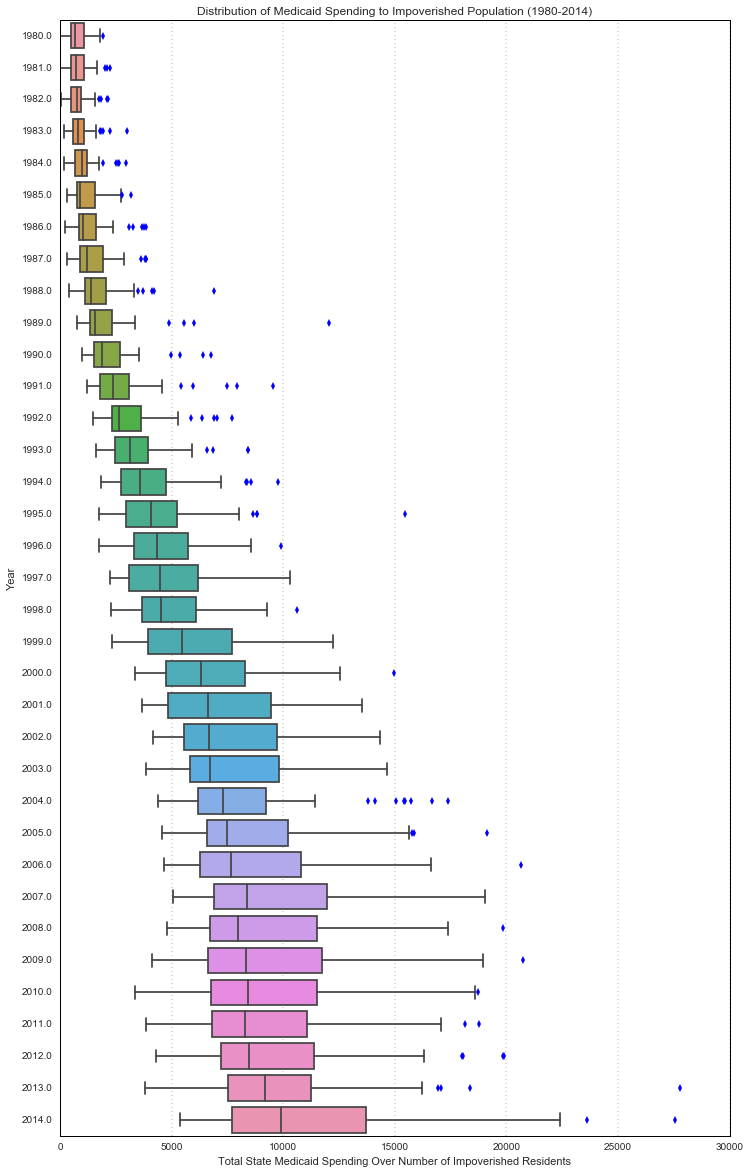

In [152]:
#Generate plot object
fig,ax=plt.subplots(figsize=(12,20))

#Generate box plot
sb.boxplot(x='mcaid_ip',y='year',data=pov.reset_index(),ax=ax,orient='h')

#Fix labels
ax.set_title('Distribution of Medicaid Spending to Impoverished Population (1980-2014)')
ax.set_xlabel('Total State Medicaid Spending Over Number of Impoverished Residents')
ax.set_ylabel('Year');

What's happening with the folks receiving over $15k a year?  That seems high.

In [151]:
pov[pov['mcaid_ip']>15000]

pop      num_pov  st_err_num    pct_pov  \
state         year                                                     
Alaska        2004    648.000000    59.000000    7.000000   9.100000   
              2005    657.000000    66.000000    7.000000  10.000000   
              2006    658.000000    58.000000    7.000000   8.900000   
              2007    675.000000    51.000000    7.000000   7.600000   
              2008    672.000000    55.000000    7.000000   8.200000   
              2011    712.000000    83.000000    9.000000  11.700000   
              2012    701.772828    70.061416    8.036155   9.983489   
              2013    695.949329    76.160779   11.967625  10.943437   
              2014    694.000000    82.000000    8.000000  11.853000   
Connecticut   2006   3457.000000   275.000000   34.000000   8.000000   
              2008   3433.000000   276.000000   34.000000   8.100000   
              2009   3472.000000   292.000000   35.000000   8.400000   
              2010   3541.000000   303.000000   27.000000   8.600000   
              2011   3514.000000   356.000000   33.000000  10.100000   
              2012   3516.849604   362.721950   30.111726  10.313832   
              2013   3544.966592   400.474035   35.973761  11.296976   
              2014   3577.000000   308.000000   44.000000   8.605000   
Delaware      2014    929.000000   103.000000   10.000000  11.043000   
Maine         2009   1297.000000   148.000000   16.000000  11.400000   
              2013   1310.082713   160.500162   17.243761  12.251147   
Maryland      2014   5934.000000   584.000000   55.000000   9.850000   
Massachusetts 2004   6363.000000   594.000000   55.000000   9.300000   
              2005   6318.000000   641.000000   57.000000  10.100000   
              2008   6420.000000   727.000000   60.000000  11.300000   
              2009   6623.000000   717.000000   60.000000  10.800000   
              2010   6532.000000   711.000000   68.000000  10.900000   
              2011   6514.000000   688.000000   55.000000  10.600000   
              2012   6565.681969   743.004018   58.807855  11.316479   
              2013   6569.791069   784.252603   92.551541  11.937253   
              2014   6653.000000   902.000000   71.000000  13.553000   
...                          ...          ...         ...        ...   
New Hampshire 2004   1291.000000    71.000000   11.000000   5.500000   
              2005   1298.000000    73.000000   11.000000   5.600000   
              2006   1308.000000    71.000000   11.000000   5.400000   
              2007   1312.000000    76.000000   11.000000   5.800000   
              2010   1294.000000    84.000000    8.000000   6.500000   
              2014   1318.000000    95.000000   11.000000   7.200000   
New York      2004  19010.000000  2847.000000  122.000000  15.000000   
              2005  18995.000000  2760.000000  121.000000  14.500000   
              2006  19021.000000  2668.000000  119.000000  14.000000   
              2007  19021.000000  2757.000000  121.000000  14.500000   
              2008  19309.000000  2734.000000  120.000000  14.200000   
              2009  19158.000000  3018.000000  125.000000  15.800000   
              2010  19116.000000  3062.000000  147.000000  16.000000   
              2011  19329.000000  3085.000000  144.000000  16.000000   
              2012  19297.532930  3328.035860  130.940777  17.245914   
              2013  19487.810010  2825.319766  163.658322  14.497882   
              2014  19658.000000  2755.000000  144.000000  14.017000   
Rhode Island  2007   1042.000000    99.000000   12.000000   9.500000   
              2014   1046.000000   119.000000   14.000000  11.341000   
Vermont       2004    616.000000    48.000000    7.000000   7.800000   
              2005    621.000000    47.000000    6.000000   7.600000   
              2006    618.000000    48.000000    6.000000   7.800000   
              2007    613.000000    61.000000    7.000000   9.900000 

Let's check this against some external sources.  First of all, how close are our NIPA values to other measures of Medicaid spending.  [KFF](http://kff.org/medicaid/state-indicator/total-medicaid-spending/#) has compiled some data by state for FY14.  Let's check proportional differences.

C:\Users\marvinw\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: order is deprecated, use sort_values(...)


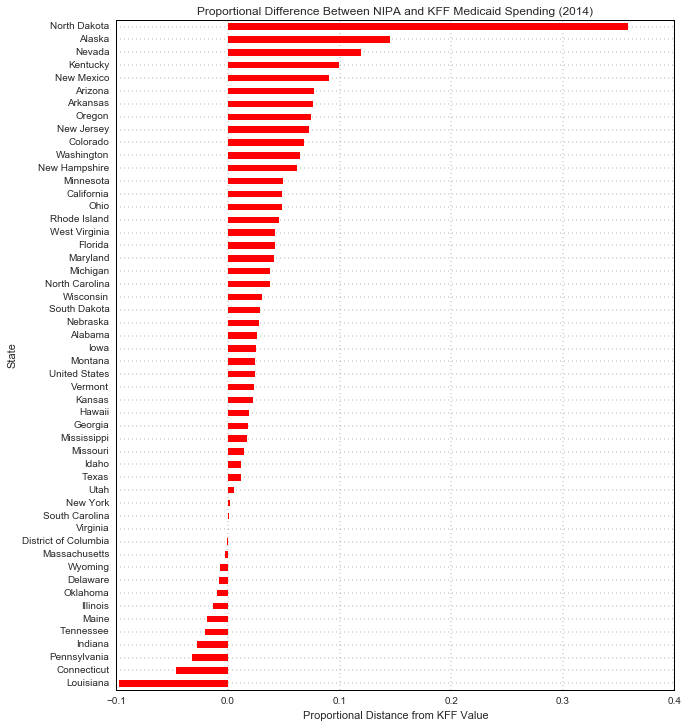

In [147]:
#Capture 2014 data from NIPA
data2014=data2['mcaid_exp'].xs(2014,level='year')

#Read in KFF data
kff_fy14=pd.read_csv('mcaid_kff_fy14.csv')

#Set index
kff_fy14.set_index('state',inplace=True)

#Join into single DF
mcaid_exp_compare=DataFrame(data2014).join(DataFrame(kff_fy14))

#Drop missing
mcaid_exp_compare=mcaid_exp_compare[mcaid_exp_compare['mcaid_kff'].notnull()]

#Convert KFF figures to $000s
mcaid_exp_compare['mcaid_kff']=mcaid_exp_compare['mcaid_kff']/1000.

#Capture difference
mcaid_exp_compare['diff']=mcaid_exp_compare['mcaid_exp']-mcaid_exp_compare['mcaid_kff']

#Capture proportion of KFF numbers
mcaid_exp_compare['diff_prop']=mcaid_exp_compare['diff']/mcaid_exp_compare['mcaid_kff']

#Generate plot object
fig,ax=plt.subplots(figsize=(10,12))

#Plot proportional difference
mcaid_exp_compare['diff_prop'].order().plot(kind='barh',ax=ax,color='r',lw=0)

#Fix labels
ax.set_title('Proportional Difference Between NIPA and KFF Medicaid Spending (2014)')
ax.set_xlabel('Proportional Distance from KFF Value')
ax.set_ylabel('State');

Some of these values are aggressively different.  The gaps are too large to be explained by FY-CY differences.  Curiously enough, the biggest gaps don't necessarily correspond to the most outrageous ratio values...

What about our population figures?  The impoverished population is based upon the folks for whom Census could come to a poverty determination.  This is different from the Census count of total population.  How much might this be moving the ratio?

In [128]:
DataFrame(mcaid_exp_compare['diff_prop']).reset_index()['state']

0                  Alabama
1                   Alaska
2                  Arizona
3                 Arkansas
4               California
5                 Colorado
6              Connecticut
7                 Delaware
8     District of Columbia
9                 Far West
10                 Florida
11                 Georgia
12             Great Lakes
13                  Hawaii
14                   Idaho
15                Illinois
16                 Indiana
17                    Iowa
18                  Kansas
19                Kentucky
20               Louisiana
21                   Maine
22                Maryland
23           Massachusetts
24                Michigan
25                 Mideast
26               Minnesota
27             Mississippi
28                Missouri
29                 Montana
30                Nebraska
31                  Nevada
32             New England
33           New Hampshire
34              New Jersey
35              New Mexico
36                New York
3

In [103]:
pop2010_=pd.read_csv('https://www.census.gov/popest/data/state/totals/2014/tables/NST-EST2014-01.csv',skiprows=3)

pop2010_

,Unnamed: 0,Census,Estimates Base,2010,2011,2012,2013,2014
0,United States,"308,745,538","308,758,105","309,347,057","311,721,632","314,112,078","316,497,531","318,857,056"
1,Northeast,"55,317,240","55,318,348","55,381,690","55,635,670","55,832,038","56,028,220","56,152,333"
2,Midwest,"66,927,001","66,929,898","66,972,390","67,149,657","67,331,458","67,567,871","67,745,108"
3,South,"114,555,744","114,562,951","114,871,231","116,089,908","117,346,322","118,522,802","119,771,934"
4,West,"71,945,553","71,946,908","72,121,746","72,846,397","73,602,260","74,378,638","75,187,681"
5,.Alabama,"4,779,736","4,780,127","4,785,822","4,801,695","4,817,484","4,833,996","4,849,377"
6,.Alaska,"710,231","710,249","713,856","722,572","731,081","737,259","736,732"
7,.Arizona,"6,392,017","6,392,310","6,411,999","6,472,867","6,556,236","6,634,997","6,731,484"
8,.Arkansas,"2,915,918","2,915,958","2,922,297","2,938,430","2,949,300","2,958,765","2,966,369"
9,.California,"37,253,956","37,254,503","37,336,011","37,701,901","38,062,780","38,431,393","38,802,500"
